# Image classification using LoRA with Vision Transformers

## Introduction

In this notebook, we will learn how to use [LoRA](https://arxiv.org/abs/2106.09685) from 🤗 PEFT to fine-tune an image classification model by ONLY using **0.72%** of the original trainable parameters of the model.

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://arxiv.org/abs/2106.09685).


__*Note that this notebook builds on top the [image classification with LoRA notebook](https://huggingface.co/docs/peft/task_guides/image_classification_lora).*__

## What is LoRA

![LoRA illisturation](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png)

LoRA (Low-rank Optimization for Rapid Adaptation) is a parameter-efficient training method that utilizes low-rank decomposition to reduce the number of trainable parameters. Instead of updating the entire weight matrix, LoRA employs smaller matrices that adapt to new data while maintaining the original weight matrix. This approach offers several benefits:


1.   Reduced Trainable Parameters: LoRA significantly reduces the number of trainable parameters, leading to faster training and reduced memory consumption.
2.   Frozen Pre-trained Weights: The original weight matrix remains frozen, allowing it to be used as a foundation for multiple lightweight LoRA models. This facilitates efficient transfer learning and domain adaptation.
3.  Compatibility with Other Parameter-Efficient Methods: LoRA can be seamlessly integrated with other parameter-efficient techniques, such as knowledge distillation and pruning, further enhancing model efficiency.
4.  Comparable Performance: LoRA achieves performance comparable to fully fine-tuned models, demonstrating its effectiveness in preserving model accuracy despite reducing trainable parameters.



Let's get started by installing the dependencies.

## Imports
---

In [1]:
!pip install datasets
!pip install evaluate
!pip install accelerate -U
!pip install transformers accelerate evaluate datasets git+https://github.com/huggingface/peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 920.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as T
from datasets import load_dataset
from transformers import AutoImageProcessor, ViTForImageClassification
from transformers import Trainer, TrainingArguments
import evaluate

## Loading the Dataset
---

- We'll be using [Oxford-IIIT Pets Dataset](https://huggingface.co/datasets/pcuenq/oxford-pets)
- It is a collection of 37 different cat and dog breed images.

In [3]:
dataset = load_dataset('pcuenq/oxford-pets')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7390 [00:00<?, ? examples/s]

The dataset contains the following features:

- path: a path to the file
- label: the breed of the animal
- dog: indicates if the animal is a dog or not
- image: a PIL Image

In [4]:
dataset['train'][0]

{'path': '/data/datasets/magic-ml/oxford-iiit-pet/images/Siamese_137.jpg',
 'label': 'Siamese',
 'dog': False,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=345x500>}

In [5]:
classes = dataset['train'].unique('label')
print(len(classes),classes)

37 ['Siamese', 'Birman', 'shiba inu', 'staffordshire bull terrier', 'basset hound', 'Bombay', 'japanese chin', 'chihuahua', 'german shorthaired', 'pomeranian', 'beagle', 'english cocker spaniel', 'american pit bull terrier', 'Ragdoll', 'Persian', 'Egyptian Mau', 'miniature pinscher', 'Sphynx', 'Maine Coon', 'keeshond', 'yorkshire terrier', 'havanese', 'leonberger', 'wheaten terrier', 'american bulldog', 'english setter', 'boxer', 'newfoundland', 'Bengal', 'samoyed', 'British Shorthair', 'great pyrenees', 'Abyssinian', 'pug', 'saint bernard', 'Russian Blue', 'scottish terrier']


We'll also map the label names to indices with `label2id` and `id2label` so it is easy for us to read.

In [6]:
label2id = {c:idx for idx,c in enumerate(classes)}
id2label = {idx:c for idx,c in enumerate(classes)}

#### Here are some sample images from the dataset

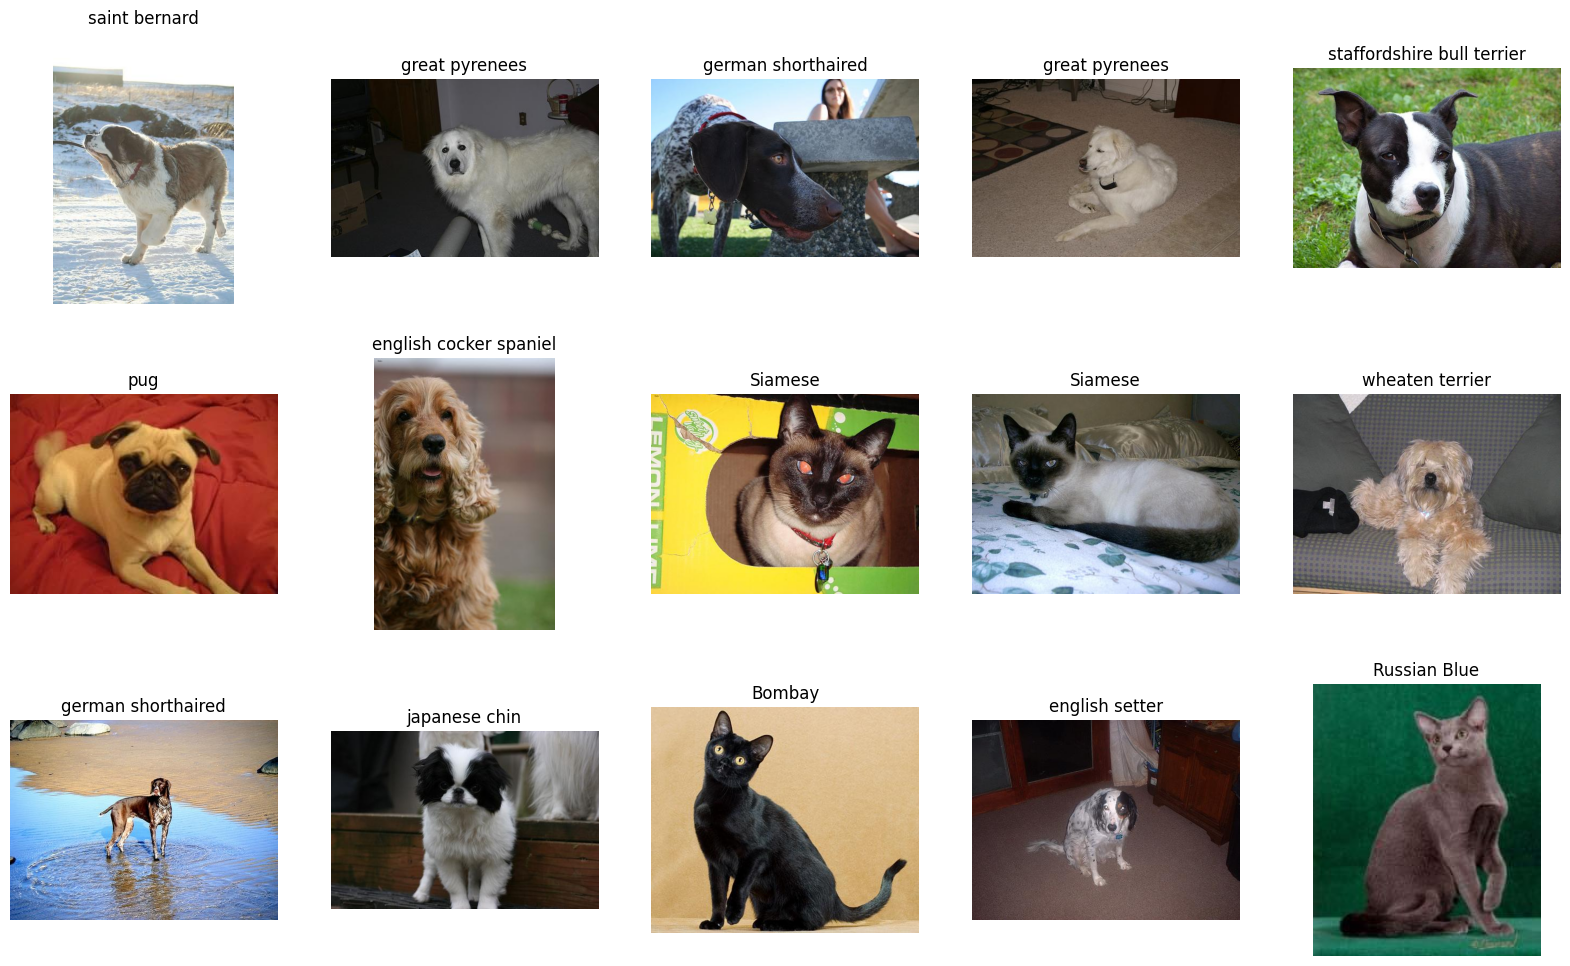

In [7]:
def show_samples(ds,rows=2,cols=4):
    samples = ds.shuffle().select(np.arange(rows*cols))
    fig = plt.figure(figsize=(cols*4,rows*4))
    for i in range(rows*cols):
        img = samples[i]['image']
        label = samples[i]['label']
        fig.add_subplot(rows,cols,i+1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_samples(dataset['train'],rows=3,cols=5)

## Preprocessing
---

Let's first split the dataset into `train` for training and `test` for evaluation.

In [8]:
dataset = dataset['train'].train_test_split(train_size=0.8)
dataset

DatasetDict({
    train: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 5912
    })
    test: Dataset({
        features: ['path', 'label', 'dog', 'image'],
        num_rows: 1478
    })
})

To prepare the inputs for the model, we have to apply transformations, which we can using `AutoImageProcessor` to load the right transformations corresponding to the model we are using. We can see which transformations are used in the processor config.

In [9]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

To apply the transformations to a batch at the time of training, we can create a function which will preprocess the batch. The trainer will call this function when we add it to the dataset using `with_transform`.

In this `transforms` function, we do the following:

- It maybe possible that some images in your dataset will be grayscale or transparent (RBGA). To avoid dimension errors, it is safer to convert them to RGB using PIL `convert` method.
- We pass the images through the processor to apply the transforms, and to also convert them into PyTorch format.
- Using `label2id` we convert the String labels to their integer representation.

In [10]:
def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor([x for x in batch['image']],return_tensors='pt')
    inputs['labels']=[label2id[y] for y in batch['label']]
    return inputs

In [11]:
dataset = dataset.with_transform(transforms)

We also define `collate_fn` to collate our data into batches for the model in the right way.

In [12]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

## Metric
---

We can use Hugging Face `evaluate` library to calculate metrics. For image classification, we can use the accuracy metric

In [13]:
#
accuracy = evaluate.load('accuracy')
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits,axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    return acc

Before loading the model, let’s define a helper function to check the total number of parameters a model has, as well as how many of them are trainable.

In [14]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

## Model
---

For transfer learning we do not need to update the parameters of the entire model. Vision Transformers are pre-trained on large-scale image datasets so they already have a wide range of feature representations.

To load our pre-trained ViT model, we will use `ViTForImageClassification` class. We do need to update the final `classifier` layer, to output predictions equal to the number of labels in our dataset. We will do that by passing in `num_labels` argument along with our label mappings `id2label` and `label2id`.

We also need to pass `ignore_mismatched_sizes = True` to compensate for the change in number of parameters in the `classifier` layer.

In [15]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([37]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([37, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85827109 || all params: 85827109 || trainable%: 100.00


Next, we use get_peft_model to wrap the base model so that “update” matrices are added to the respective places.

In [16]:
#added

from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)

lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 618277 || all params: 86445386 || trainable%: 0.72


### Let's examine the LoraConfig Parameters:
- `r`: The rank of the update matrices, represented as an integer. Lower rank values result in smaller update matrices with fewer trainable parameters.

- `target_modules`: The modules (such as attention blocks) where the LoRA update matrices should be applied.

- `alpha`: The scaling factor for LoRA.

- `layers_pattern`: A pattern used to match layer names in `target_modules` if `layers_to_transform` is specified. By default, PeftModel will use a common layer pattern (layers, h, blocks, etc.). This pattern can also be used for exotic and custom models.

- `rank_pattern`: A mapping from layer names or regular expression expressions to ranks that differ from the default rank specified by `r`.

- `alpha_pattern`: A mapping from layer names or regular expression expressions to alphas that differ from the default alpha specified by `lora_alpha`.

#### Here's our model architecture

In [17]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): lora.Linear(
                (base_layer): Linear(in_features=768, out_features=768, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=768, bias=False)
                )
                (lora_embedding_A): ParameterDict()
     


### Let's look at the components of the LoRA model:

- **lora.Linear**: LoRA adapts pre-trained models using a low-rank decomposition. It modifies the linear transformation layers (query, key, value) in the attention mechanism.
  - **base_layer**: The original linear transformation.
  - **lora_dropout**: Dropout applied to the LoRA parameters.
  - **lora_A**: The matrix A in the low-rank decomposition.
  - **lora_B**: The matrix B in the low-rank decomposition.
  - **lora_embedding_A/B**: The learnable embeddings for LoRA.

# Training
---

We'll use HuggingFace Trainer to train our model, we can set our desired training arguments and start the training.

In [18]:
batch_size = 128

args = TrainingArguments(
    output_dir="./vit-base-oxford-iiit-pets",
    per_device_train_batch_size=batch_size,
    learning_rate=5e-3,
    num_train_epochs=5,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    logging_steps=10,
    save_total_limit=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    report_to='tensorboard',
    fp16=True,
    remove_unused_columns=False,
    load_best_model_at_end=True,
)

In [19]:
trainer = Trainer(
    model=model,
    args=args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor
)

In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.929300,0.205929,0.934371
1,0.156300,0.193903,0.940460
2,0.080800,0.170276,0.949932
4,0.025000,0.172827,0.951286


TrainOutput(global_step=55, training_loss=0.22645356167446484, metrics={'train_runtime': 753.7585, 'train_samples_per_second': 39.217, 'train_steps_per_second': 0.073, 'total_flos': 2.166104653885735e+18, 'train_loss': 0.22645356167446484, 'epoch': 4.68})

Let's save the model

In [21]:
trainer.save_model()

For more information you can check:


*   [Hugging Face Image Classification using LoRA](https://huggingface.co/docs/peft/task_guides/image_classification_lora)
*   [CONCEPTUAL LoRA GUIDE](https://huggingface.co/docs/peft/conceptual_guides/lora)
*   [Computer Vision COurse Image Classification with Transer Learning](https://github.com/shreydan/computer-vision-course/blob/main/notebooks/Unit%203%20-%20Vision%20Transformers/transfer-learning.ipynb)